In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
Smarket = load_data('Smarket')

In [4]:
Smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [5]:
# pass the numeric_only argument to avoid getting the error for categorical columns
Smarket.corr(numeric_only = True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


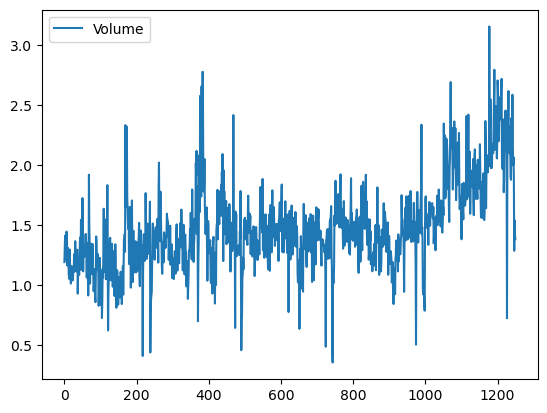

In [6]:
Smarket.plot(y = 'Volume');

In [7]:
"""
Logistic regression
"""

'\nLogistic regression\n'

In [8]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

# pass the family argument as binomial. else the data will be assumed to belong to some other distribution
# the default family is Gaussian

glm = sm.GLM(y, X, family = sm.families.Binomial())

# else we can execute 
#glm = sm.Logit(y,X)

results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [9]:
probs = results.predict()

In [10]:
Smarket.shape

(1250, 9)

In [11]:
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = 'Up'

In [12]:
# confusion_table - ISLP package function similar to sklearn.metrics
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [13]:
model_accuracy = (145 + 507) / 1250
model_accuracy

0.5216

In [14]:
train = (Smarket.Year < 2005)

Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
print(Smarket_train.shape, Smarket.shape)

(998, 9) (1250, 9)


In [15]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog = X_test)

In [16]:
D = Smarket.Direction
Label_train, Label_test = D.loc[train], D.loc[~train]

In [17]:
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, Label_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [18]:
np.mean(labels == Label_test), np.mean(labels != Label_test)

(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

In [19]:
# use only the 2 lowest p value indicators
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train, X_train, family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog = X_test)
labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, Label_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [20]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

In [21]:
"""
Linear Discriminant Analysis (LDA)
"""

'\nLinear Discriminant Analysis (LDA)\n'

In [22]:
# store the covariance matrix, in case we need to fetch it and analyse
lda = LDA( store_covariance = True )

# we need to drop the intercept added in the dataset. because the LDA adds the intercept itself
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]

# label as available in the original dataset itself can be used to train LDA
lda.fit(X_train, Label_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [23]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [24]:
# means of the coefficients within each class
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [25]:
"""
output should be read like this


| Class   | Feature 1 mean | Feature 2 mean |
| ------- | -------------- | -------------- |
| Class 0 | 0.0428         | 0.0339         |
| Class 1 | −0.0395        | −0.0313        |

"""

'\noutput should be read like this\n\n\n| Class   | Feature 1 mean | Feature 2 mean |\n| ------- | -------------- | -------------- |\n| Class 0 | 0.0428         | 0.0339         |\n| Class 1 | −0.0395        | −0.0313        |\n\n'

In [26]:
# the class probability from the whole dataset calculated by lda
lda.priors_

array([0.49198397, 0.50801603])

In [27]:
# common covariance matrix for all the classes
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

In [28]:
lda.scalings_
# detailed explanation about this will be included in the README section of this chapter

array([[-0.64201904],
       [-0.51352928]])

In [29]:
"""
from text book - 
These values provide the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule. 
If $-0.64\times Lag1 - 0.51 \times Lag2 $ is large, then the LDA classifier will predict a market increase, 
and if it is small, then the LDA classifier will predict a market decline.
"""

'\nfrom text book - \nThese values provide the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule. \nIf $-0.64\times Lag1 - 0.51 \times Lag2 $ is large, then the LDA classifier will predict a market increase, \nand if it is small, then the LDA classifier will predict a market decline.\n'

In [30]:
lda_pred = lda.predict(X_test)

In [31]:
confusion_table(lda_pred, Label_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [55]:
(106+35)/252

0.5595238095238095

In [56]:
np.mean(lda_pred == Label_test)

np.float64(0.5595238095238095)

In [32]:
pd.concat(
    [X_test.reset_index(drop=True),
     Label_test.reset_index(drop=True),
     pd.Series(lda_pred, name="Pred")],
    axis=1
).head(10)

,Lag1,Lag2,Direction,Pred
0,-0.134,0.008,Down,Up
1,-0.812,-0.134,Down,Up
2,-1.167,-0.812,Down,Up
3,-0.363,-1.167,Up,Up
4,0.351,-0.363,Down,Up
5,-0.143,0.351,Up,Up
6,0.342,-0.143,Down,Up
7,-0.610,0.342,Up,Up
8,0.398,-0.610,Down,Up
9,-0.863,0.398,Up,Up


In [34]:
# predict the probability of each class for observations
lda_prob = lda.predict_proba(X_test)

# check the rows on which the prob of market going Down is more than 90%
np.sum(lda_prob[:,0] > 0.9)

np.int64(0)

In [ ]:
"""
Quadratic Discriminant Analysis (QDA)
"""

In [35]:
qda = QDA(store_covariance=True)
qda.fit(X_train, Label_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [36]:
qda.means_, qda.priors_
# means and priors are same for the classes as calculated by LDA

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [37]:
# one covariance matrix per class
qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [38]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, Label_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [39]:
np.mean(qda_pred == Label_test)

np.float64(0.5992063492063492)

In [40]:
151/252

0.5992063492063492

In [58]:
# predict the probability of each class for observations
qda.predict_proba(X_test)[:5]

array([[0.48732434, 0.51267566],
       [0.47590106, 0.52409894],
       [0.46369106, 0.53630894],
       [0.4739253 , 0.5260747 ],
       [0.49034262, 0.50965738]])

In [ ]:
"""
Naive Bayes
"""

In [42]:
NB = GaussianNB()
NB.fit(X_train, Label_train)

GaussianNB()

In [43]:
print(NB.classes_, NB.class_prior_)

['Down' 'Up'] [0.49198397 0.50801603]


In [44]:
# per class, per feature means
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [47]:
X_train[Label_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [48]:
X_train[Label_train == 'Up'].mean()

Lag1   -0.039546
Lag2   -0.031325
dtype: float64

In [45]:
# per class, per feature variances
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [50]:
X_train[Label_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [51]:
X_train[Label_train == 'Up'].var(ddof=0)

Lag1    1.514014
Lag2    1.487329
dtype: float64

In [52]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, Label_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [53]:
np.mean(nb_labels == Label_test)

np.float64(0.5952380952380952)

In [54]:
(121+29)/252

0.5952380952380952

In [ ]:
"""
Naive bayes is slightly worse than QDA, but better than LDA in this dataset
"""

In [57]:
# predict the probability of each class for observations
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

In [ ]:
"""
K nearest neighbours
"""

In [59]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, Label_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, Label_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [61]:
(83+43)/252, np.mean(knn1_pred == Label_test)

(0.5, np.float64(0.5))

In [63]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, Label_train).predict(X_test)
np.mean(knn3_pred == Label_test)

np.float64(0.5317460317460317)

In [ ]:
""" 
among the 4 methods of classification, QDA performs best for the Stock market data
"""

In [64]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
# value_counts() takes a pd.Series or pd.DataFrame and returns a pd.Series with the corresponding counts for each unique element
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [65]:
feature_df = Caravan.drop(columns=['Purchase'])

In [66]:
"""
standardize the data so that all variables are given a mean of zero and a standard deviation of one
otherwise its not possible to compare the variables wont be in a comparable scale
and the distances would be far apart between each predictors in order to classify them into a cluster
"""

scaler = StandardScaler(with_mean = True, with_std = True, copy = True)

# parameters for the scaling are computed and stored
scaler.fit(feature_df)
# constructs the standardized set of features
X_std = scaler.transform(feature_df)

In [67]:
feature_std = pd.DataFrame(X_std, columns = feature_df.columns);
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [68]:
(X_train, X_test, y_train, y_test) = train_test_split(feature_std, Purchase, test_size = 1000, random_state = 0)

In [79]:
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test == "Yes")

(np.float64(0.111), np.float64(0.067))

In [ ]:
"""
error rate is just 11%. but the observations with Yes as the outcome is just 6%
so, even if the model classifies everything as 'No' the error rate would be just 6%
this is called as null rate
"""

In [71]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [73]:
# % of actual number of ppl buying the insurance in test set
(58 + 9) / 1000

0.067

In [74]:
# % of ppl actually buying from the total prediction buy counts
9 / (9 + 53)

0.14516129032258066

In [ ]:
"""
So the overall error rate is not of interest. 
Instead, the fraction of individuals that are correctly predicted to buy insurance is of interest.
"""

In [80]:
"""
number of neighbours are called as tuning or hyperparameter
in order to check which number of K produces best fit, we need to iterate the KNN classifier in a loop
"""
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
            '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


In [ ]:
"""
logistic regression
"""

In [82]:
# use a large C value, in order for the logistic regression to run
# solver = liblinear to avoid the warning that the model does not converge
# liblinear can only be used for binary classification
logit = LogisticRegression(C=1e10, solver='liblinear')

logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)

# set the threshold to 0.25
logit_labels = np.where(logit_pred[:,1] > .25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth,No,Yes
Predicted,,
No,913,58
Yes,20,9


In [83]:
# % of ppl actually buying from the total prediction buy counts
9 / (9 + 20)

0.3103448275862069

In [ ]:
"""
Linear regression for bikeshare dataset
"""

In [84]:
Bike = load_data('Bikeshare')
X = MS(['mnth', 'hr', 'workingday', 'temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M_lm = sm.OLS(Y, X).fit()
summarize(M_lm)

,coef,std err,t,P>|t|
intercept,-68.6317,5.307,-12.932,0.000
mnth[Feb],6.8452,4.287,1.597,0.110
mnth[March],16.5514,4.301,3.848,0.000
mnth[April],41.4249,4.972,8.331,0.000
mnth[May],72.5571,5.641,12.862,0.000
mnth[June],67.8187,6.544,10.364,0.000
mnth[July],45.3245,7.081,6.401,0.000
mnth[Aug],53.2430,6.640,8.019,0.000
mnth[Sept],66.6783,5.925,11.254,0.000
mnth[Oct],75.8343,4.950,15.319,0.000


In [ ]:
"""
Jan and 24th hour is considered as baseline
so the other coefficients shall be interpreted comparing to those 2
"""

In [87]:
# contrast is the ISLP method. it retains the columns, makes one column in a category as the negative sum of the rest
# and the mean is zero. here again, the coefficient interpretation shall be different
hr_encode = contrast('hr', 'sum')
mnth_encode = contrast('mnth', 'sum')
X2 = MS([mnth_encode,
         hr_encode,
        'workingday',
        'temp',
        'weathersit']).fit_transform(Bike)
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In [88]:
# to verify that the choice of coding does not matter
np.allclose(M_lm.fittedvalues, M2_lm.fittedvalues)

True

In [89]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month, 
                        pd.Series([-coef_month.sum()], 
                        index=['mnth[Dec]'])])

In [ ]:
"""
Poisson regression
"""

In [90]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()
S_pois = summarize(M_pois)

coef_month = S_pois[S_pois.index.str.contains('mnth')]['coef']
coef_month = pd.concat([coef_month,
                        pd.Series([-coef_month.sum()],
                                   index=['mnth[Dec]'])])
coef_hr = S_pois[S_pois.index.str.contains('hr')]['coef']
coef_hr = pd.concat([coef_hr,
                     pd.Series([-coef_hr.sum()],
                     index=['hr[23]'])])

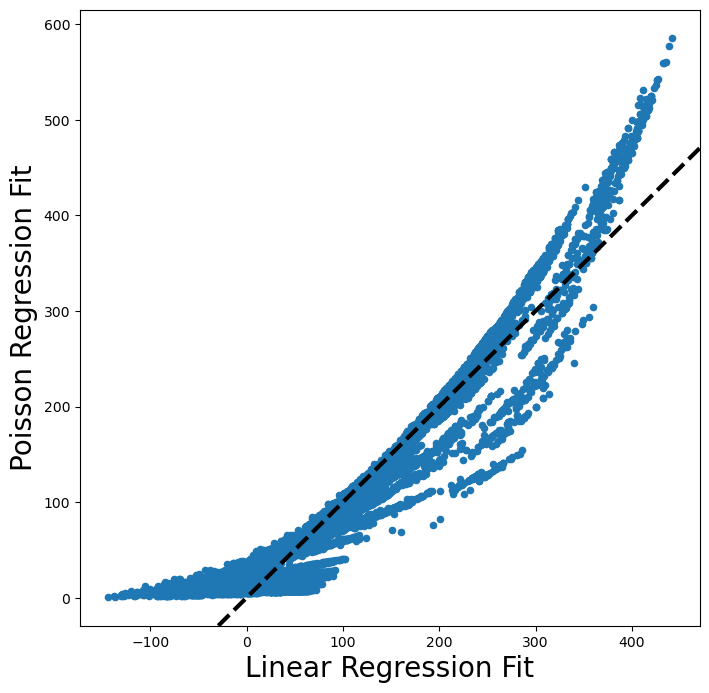

In [91]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues,
           M_pois.fittedvalues,
           s=20)
ax.set_xlabel('Linear Regression Fit', fontsize=20)
ax.set_ylabel('Poisson Regression Fit', fontsize=20)
ax.axline([0,0], c='black', linewidth=3,
          linestyle='--', slope=1);

In [ ]:
"""
Poisson regression predictions tend to be larger than those from the linear model for either very low or very high levels of ridership
"""